[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nagaoka-ai-innovationhub/basics-of-image-recognition-with-cnn/blob/master/09_basics_of_image_classification_with_cnn.ipynb)

# 畳み込みニューラルネットワークを使った画像分類の基本

今までのテクニックを使って、畳み込みニューラルネットワークを使った画像分類をしてみましょう。

In [1]:
# ColabでのTensorFlow 2.xのインストール
try:
    # %tensorflow_version は Colab 上でのみ使えます
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

# TensorFlowとtf.kerasのバージョン確認
print(tf.version.VERSION)
print(tf.keras.__version__)

2.4.0
2.4.0


## 1. データの取得

今回はラーメンとうどんの画像の分類をしてみようと思います。
実際の画像データは、講師から案内があるので、そこからダウンロードしてください。

今回の画像データは、インターネットにある画像を収集して使用します。 インターネットから画像などの情報を収集する場合は、専用のサービス (API) を使用する方法と、 HTMLドキュメントを解析するWebスクレイピングによる方法があります。 今回は専用のサービスを使用する方法で、画像を収集します。

今回使用するサービスは、Microsoftが提供している、「Bing Image Search API」を使用しています。
このAPIを使用して、インターネットに公開されている「ラーメン」と「うどん」の画像を収集します。

取得スクリプトについては、[bing_image_search_downloder.ipynb](https://github.com/kasacchiful/keras-cnn-hands-on/blob/master/bing_image_search_downloder.ipynb) (別サイト) を参照してください。

## 2. データの選別

データを取得したら、データを選別する必要があります。例えば、「ラーメン」で画像検索した結果には、ラーメンそのものの画像以外にも検索結果に入ってきます。

ラーメンそのもの以外の画像など、本来は学習に必要ない画像は取り除く必要があります。
今回はラーメンやうどんには関係なさそうな画像も一部学習データに混ざった状態になっていますが、そのまま学習のデータとして使用します。

また、取得したデータを学習するため、以下の3つのディレクトリに分けて保存します。

- train
    - モデルの学習に使用します。
- validation
    - モデルの学習中に、未知のデータに対してどれだけ精度が上がっているかを検証するために使用します。
- test
    - モデルの学習が終わった後で、実際の推論時に使用します。

ラーメン、うどん各々の画像に対して、trainデータ300件、validationデータ100件、testデータ100件ずつ格納していきます。

画像の保存フォルダには、以下のようになっています。

```
noodles
├── test
│   ├── ramen
│   │   ├── 007a9f3ee253e4e00e91a86f79d96251.jpg
│   │   ├── 01b2931a076face741042e491d03d03c.jpg
│   │   ├── 047a34512b2f554df476f924956d9324.jpg
│   │   ├── 11cb359269c9b59de1c150e4a21b6266.jpg
│   │   ├── 12521618a6169010cfdfa319b2cd66a6.jpg
│   │
│   │
│   └── udon
│       ├── 018e203f3bb9cfd9b407e90a2f975d30.jpg
│       ├── 0543055a3987c79c07b6abdbcd608cd6.jpg
│       ├── 094c1922e08cbd1fc5c890309a73c91a.jpg
│       ├── 111d37eb4ac7cfa268001133857db4ec.jpg
│       ├── 111ec27a535af2c06a32726a63c0629e.jpg
│
│   
├── train
│   ├── ramen
│   │   ├── 01375acfef42ca0296d994319ab370d5.jpg
│   │   ├── 02f5f33eaa99f544d1b56dd43acc12e7.jpg
│   │   ├── 03477d329e51964eca3d5350513bdc5b.jpg
│   │   ├── 03da108a718435ed77080f050bac7733.jpg
│   │   ├── 061bf905ebbba6fd7719ac3322b34f9b.jpg
│   │
│   │
│   └── udon
│       ├── 0008ccb95ea65115c9c91b973fa3d13a.jpg
│       ├── 025e6f3e0c0426c4b88737621854453f.jpg
│       ├── 02608a29fe16132807e9cbfc15a40703.jpg
│       ├── 038d39af3f843334906a0c559c2eeb64.jpg
│       ├── 047262dd8a3f5e1822aa10a828fd6433.jpg
│
│
└── validation
    ├── ramen
    │   ├── 0220d9d1e8bf2906553a81e29e08e24b.png
    │   ├── 03f8f134736f585014a340f5e9e147d1.jpg
    │   ├── 04d9bfe2d8437ed5072f2f183ad41511.jpg
    │   ├── 086cde8b41aef5076d51d73dc8d601e1.jpg
    │   ├── 08f78c8e2e53989a68d7e3b864bd579f.jpg
    │
    │
    └── udon
        ├── 0035a169051a0afbd792f30a82934a3e.jpg
        ├── 005b96c51ae7adbc7acc5c4e4a790fbb.jpg
        ├── 06078751ab342a44bedc08e235d5ef5c.jpg
        ├── 0ba18a8a8b878dd11c7076f0f71cda63.jpg
        ├── 0d3486e1682132d6bdd36a623dde48a4.jpg


```

APIで取得した画像を上記のディレクトリに格納するスクリプトは、[copy_to_train_validation_test.ipynb](https://github.com/kasacchiful/keras-cnn-hands-on/blob/master/copy_to_train_validation_test.ipynb) (別サイト) を参照ください。

### Google Colaboratoryでの設定 (学習データのコピー)

Google Colabを利用する場合は、Google Driveのマイドライブに画像データ"noodles.zip"を保存してください。
その後、以下のコマンドを利用してGoogle Driveをマウントし、
noodles.zipファイルをColabコンテナにコピーしておきましょう。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/My\ Drive/noodles.zip -d /content

### ローカルPCでの学習データのコピー

ローカルPCで実施する場合は、このノートブックが保存されているフォルダ内に'noodles.zip'を格納して、zipファイルを解凍しましょう。
解凍されたら、中の構造を確認しましょう。

`noodles`ディレクトリの中に`train`、`validation`、`test`の3つのディレクトリがありますか？
`noodles`ディレクトリの中が`noodles`になっている場合は、
その中にある`train`、`validation`、`test`ディレクトリを上部の`noodles`ディレクトリ直下に移動させてあげましょう。
（もしくは以下の入力データ生成の際のファイルパス`train_dir`、`validation_dir`、`test_dir`を書き換えてください）

## 3. モデルの構築

実際に`tf.keras`を使ってディープラーニングの学習モデルを構築していきます。 
まずは、単純な全結合層を3つほど使った多層ニューラルネットワークモデルを作っていきましょう。

### 入力データの生成

画像ファイルが格納されたディレクトリからデータを読み込んで、学習モデルに入力するための準備を行います。
今回はクラス名を指定していませんので、デフォルトの設定によりディレクトリ名順 (`['ramen', 'udon']`) にラベルが付与されます。

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './noodles/train/'
validation_dir = './noodles/validation/'
test_dir = './noodles/test/'

image_size = (128, 128)  # 入力データの縦横のサイズ。画像ファイルはこのサイズに自動的にリサイズされる。
batch_size = 32  # バッチサイズ。1度に取り込む入力データの数。

image_data_generator = ImageDataGenerator(rescale=1/255.0)
# 画像データはRGBの値が0から255までの値になっているので、
# rescaleして値を0から1までの範囲にすることで、学習の収束を早くする。

train_generator = image_data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size
)
validation_generator = image_data_generator.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size
)
test_generator = image_data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### モデルの構築

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(128,128,3)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 6,308,354
Trainable params: 6,308,354
Non-trainable params: 0
_________________________________________________________________


### モデルのコンパイル

In [5]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 4. 学習

今回は学習の過程を`history`に格納して、各エポックでの損失と正答率をグラフ化します。
また、各エポック終了時に、`validation`データによる検証を行い、その値も`history`に格納しています。
各エポックでの未知のデータを入力した時にどの程度効果的なのかを知ることができます。

In [6]:
epochs = 10  # エポック数。全ての入力データを何回繰り返して学習するかを指定する。

In [7]:
# 学習の推移を、historyに格納しておく
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/10
19/19 [==============================] - 29s 2s/step - loss: 9.9751 - accuracy: 0.4482 - val_loss: 2.2313 - val_accuracy: 0.5050
Epoch 2/10
19/19 [==============================] - 27s 1s/step - loss: 1.7875 - accuracy: 0.5681 - val_loss: 0.7055 - val_accuracy: 0.6850
Epoch 3/10
19/19 [==============================] - 28s 1s/step - loss: 0.6711 - accuracy: 0.6845 - val_loss: 0.6141 - val_accuracy: 0.6950
Epoch 4/10
19/19 [==============================] - 28s 1s/step - loss: 0.5240 - accuracy: 0.7514 - val_loss: 0.8603 - val_accuracy: 0.5900
Epoch 5/10
19/19 [==============================] - 29s 2s/step - loss: 0.7592 - accuracy: 0.6627 - val_loss: 0.6087 - val_accuracy: 0.7150
Epoch 6/10
19/19 [==============================] - 30s 2s/step - loss: 0.5654 - accuracy: 0.7735 - val_loss: 1.4702 - val_accuracy: 0.5150
Epoch 7/10
19/19 [==============================] - 38s 2s/step - loss: 0.8393 - accuracy: 0.6358 - val_loss: 0.6591 - val_accuracy: 0.6650
Epoch 8/10
19/19 [==

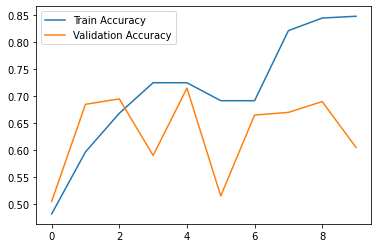

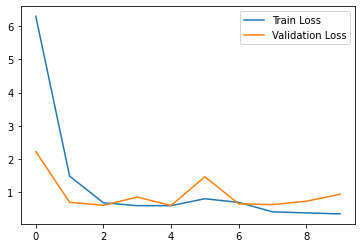

In [8]:
# 学習の推移をグラフ化してみてみよう。
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']  # 学習データの正答率
val_acc = history.history['val_accuracy']  # 検証データの正答率
loss = history.history['loss']  # 学習データの損失
val_loss = history.history['val_loss']  # 検証データの損失

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()

`train`の損失や正答率は、学習を重ねる毎に少しずつ改善されていることがうかがえます。

`validation`の損失や正答率を見ると、3エポック以降損失が0.5から1.5の間で値が収束していますが、正答率が大きくぶれているので、あまり学習できていないことがうかがえます。

念の為、今作った学習済モデルを保存しておきましょう。

In [9]:
# 学習モデルを保存
model.save('noodle_model_nn.h5')

## 5. 推論

学習済モデルを使って、テストデータを推論してみましょう。

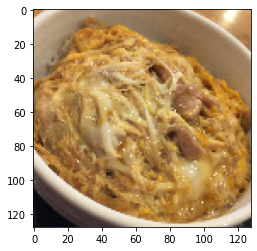

推定： うどん
正解： うどん


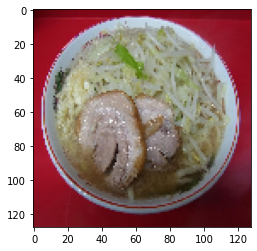

推定： ラーメン
正解： ラーメン


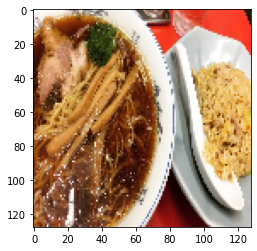

推定： うどん
正解： ラーメン


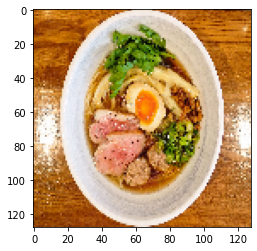

推定： うどん
正解： ラーメン


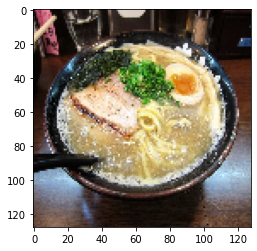

推定： うどん
正解： ラーメン


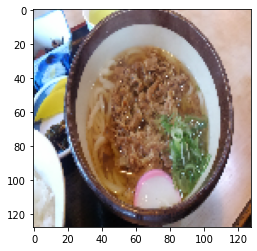

推定： うどん
正解： うどん


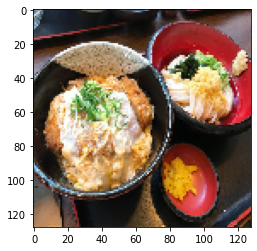

推定： うどん
正解： うどん


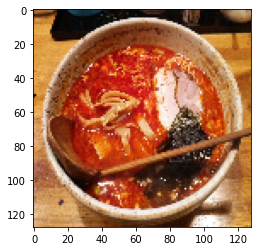

推定： ラーメン
正解： ラーメン


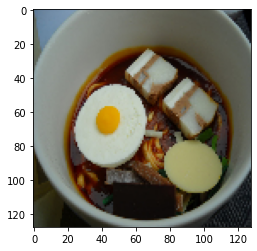

推定： うどん
正解： ラーメン


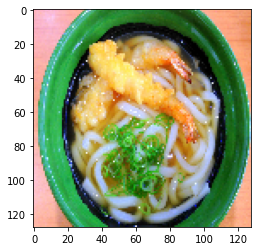

推定： うどん
正解： うどん


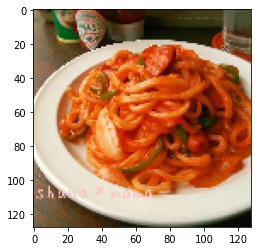

推定： うどん
正解： うどん


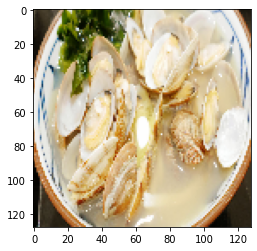

推定： うどん
正解： うどん


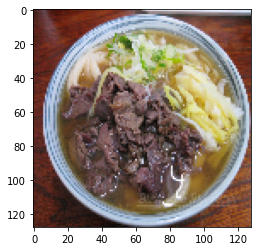

推定： うどん
正解： うどん


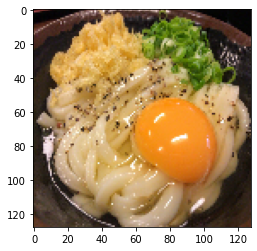

推定： うどん
正解： うどん


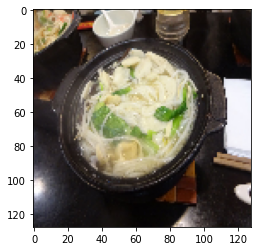

推定： うどん
正解： うどん


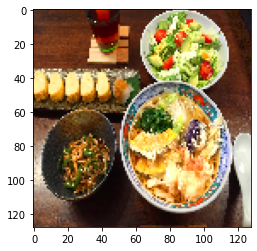

推定： ラーメン
正解： うどん


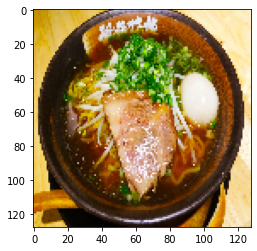

推定： うどん
正解： ラーメン


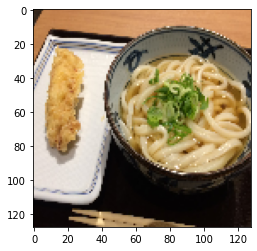

推定： うどん
正解： うどん


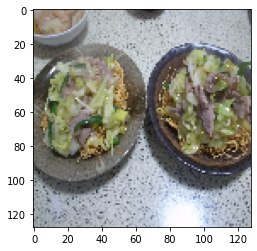

推定： うどん
正解： うどん


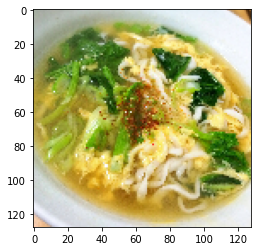

推定： うどん
正解： うどん


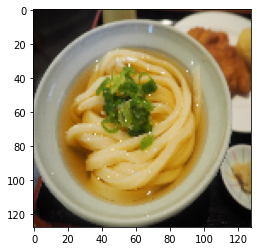

推定： うどん
正解： うどん


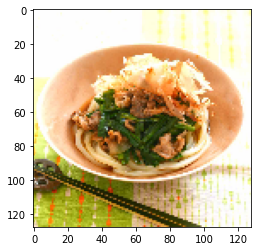

推定： うどん
正解： うどん


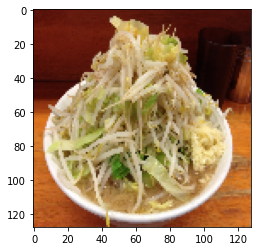

推定： ラーメン
正解： ラーメン


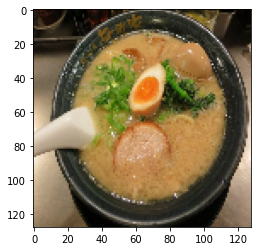

推定： うどん
正解： ラーメン


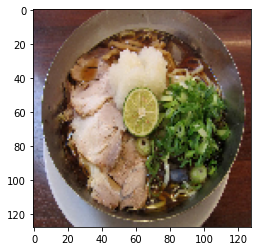

推定： うどん
正解： ラーメン


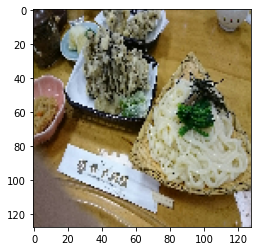

推定： ラーメン
正解： うどん


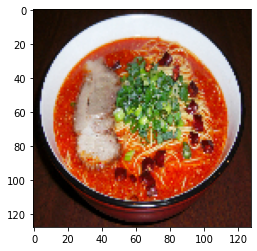

推定： うどん
正解： ラーメン


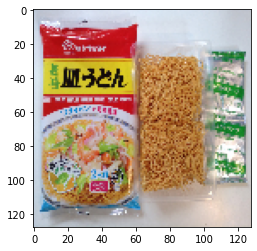

推定： うどん
正解： うどん


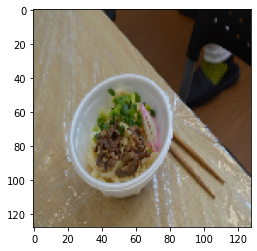

推定： うどん
正解： うどん


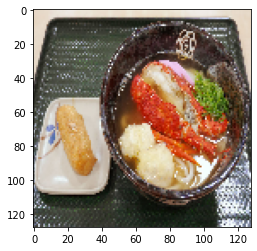

推定： うどん
正解： うどん


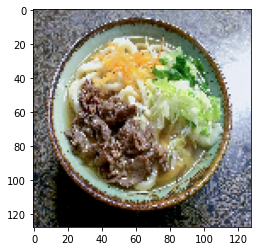

推定： うどん
正解： うどん


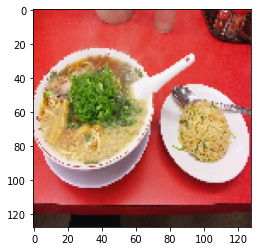

推定： ラーメン
正解： ラーメン


In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

code_to_class = {0: 'ラーメン', 1: 'うどん'}

x, y = next(test_generator)
y_true = np.argmax(y, axis=1)
y_prob = model.predict_on_batch(x)
y_pred = np.argmax(y_prob, axis=1)

for i in range(len(x)):
    plt.imshow(x[i])
    plt.show()
    print('推定：', code_to_class[y_pred[i]])
    print('正解：', code_to_class[y_true[i]])

結果を混同行列を使って確認してみましょう。混同行列とは以下のような表になっています。

|↓教師データ ／ 出力結果→| 0: ラーメン | 1: うどん |
|:---|:---|:---|
|0: ラーメン|正しくラーメンと判定した|ラーメンなのに、うどんと判定した|
|1: うどん|うどんなのに、ラーメンと判定した|正しくうどんと判定した|

この中では対角線上にある、「正しくラーメンと判定した」と「正しくうどんと判定した」に該当すると正答となります。

In [11]:
# 混同行列で見てみる
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[ 4  8]
 [ 2 18]]


[[ 4  8]
 [ 2 18]]


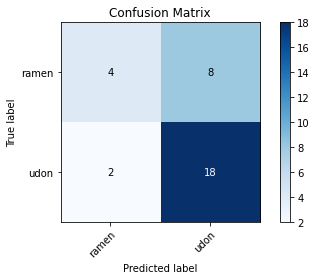

In [12]:
# おまけ
# 混同行列をもっと見やすく (参考: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['ramen', 'udon']

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title='Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
plot_confusion_matrix(y_true, y_pred, classes=class_names)
plt.show()

混同行列を見ると、推論結果が"うどん"に偏っているようです。

## 畳み込みニューラルネットワークでの画像分類

全結合層のみのネットワークは精度がいいとは言えませんね。 そこで、先ほどのモデルを改良して、今度は畳込みニューラルネットワークを構築します。

### 入力データの生成

先ほどと同じです。

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './noodles/train/'
validation_dir = './noodles/validation/'
test_dir = './noodles/test/'

image_size = (128, 128)  # 入力データの縦横のサイズ。画像ファイルはこのサイズに自動的にリサイズされる。
batch_size = 32  # バッチサイズ。1度に取り込む入力データの数。

image_data_generator = ImageDataGenerator(rescale=1/255.0)
# 画像データはRGBの値が0から255までの値になっているので、
# rescaleして値を0から1までの範囲にすることで、学習の収束を早くする。

train_generator = image_data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size
)
validation_generator = image_data_generator.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size
)
test_generator = image_data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### モデルの構築

以下のように構築してみます。

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), strides=(1,1), activation='relu', input_shape=(128,128,3)))
model.add(layers.MaxPool2D((2,2), strides=(2,2)))

model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(layers.MaxPool2D((2,2), strides=(2,2)))

model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu'))
model.add(layers.MaxPool2D((2,2), strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

### モデルのコンパイル

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 学習

In [17]:
epochs = 10  # エポック数。全ての入力データを何回繰り返して学習するかを指定する。

In [18]:
# 学習の推移を、historyに格納しておく
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/10
19/19 [==============================] - 41s 2s/step - loss: 0.7172 - accuracy: 0.5637 - val_loss: 0.6656 - val_accuracy: 0.6050
Epoch 2/10
19/19 [==============================] - 40s 2s/step - loss: 0.6325 - accuracy: 0.6557 - val_loss: 0.5766 - val_accuracy: 0.6900
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 0.4890 - accuracy: 0.7860 - val_loss: 0.5815 - val_accuracy: 0.7100
Epoch 4/10
19/19 [==============================] - 37s 2s/step - loss: 0.4523 - accuracy: 0.7917 - val_loss: 0.5536 - val_accuracy: 0.7350
Epoch 5/10
19/19 [==============================] - 37s 2s/step - loss: 0.3653 - accuracy: 0.8386 - val_loss: 0.6508 - val_accuracy: 0.7000
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 0.3165 - accuracy: 0.8562 - val_loss: 0.6818 - val_accuracy: 0.6550
Epoch 7/10
19/19 [==============================] - 37s 2s/step - loss: 0.2479 - accuracy: 0.9088 - val_loss: 0.7106 - val_accuracy: 0.6550
Epoch 8/10
19/19 [==

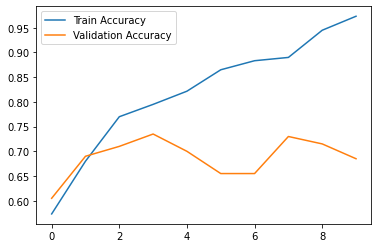

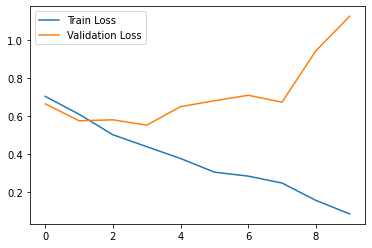

In [19]:
# 学習の推移をグラフ化してみてみよう。
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']  # 学習データの正答率
val_acc = history.history['val_accuracy']  # 検証データの正答率
loss = history.history['loss']  # 学習データの損失
val_loss = history.history['val_loss']  # 検証データの損失

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()

今回のモデルでは、`train`の損失や正答率はかなり改善しています。

対して、`validation`の損失や正答率を見ると、全結合層のみのモデルより性能は改善されてます。ただし、3エポック以降は損失や正答率が改善せず性能が悪化しています。これは過学習という状態が発生していると思われます。
過学習への対策は次章で説明します。

In [20]:
# 学習モデルを保存
model.save('noodle_model_cnn.h5')

### 推論

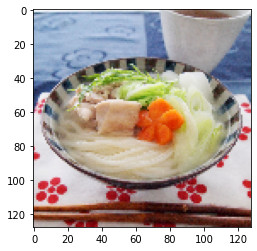

推定： うどん
正解： うどん


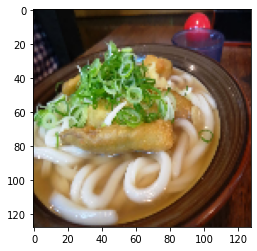

推定： ラーメン
正解： うどん


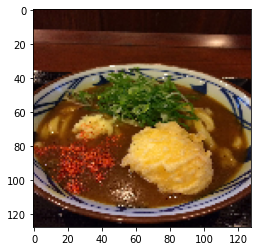

推定： うどん
正解： うどん


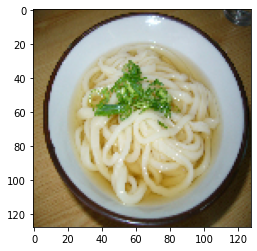

推定： ラーメン
正解： うどん


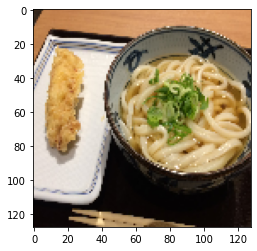

推定： うどん
正解： うどん


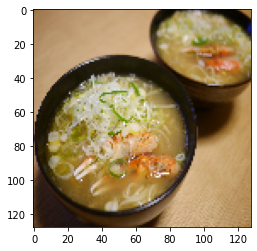

推定： うどん
正解： ラーメン


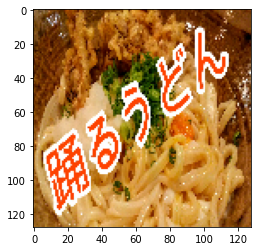

推定： うどん
正解： うどん


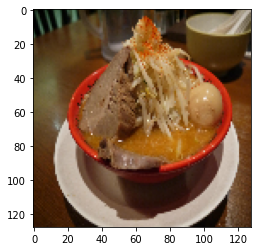

推定： ラーメン
正解： ラーメン


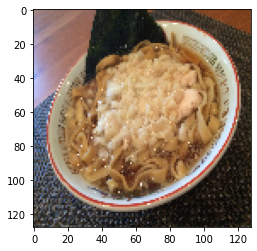

推定： うどん
正解： ラーメン


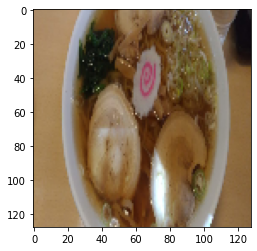

推定： うどん
正解： ラーメン


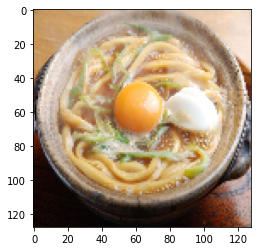

推定： うどん
正解： うどん


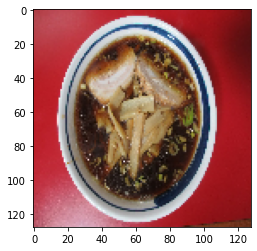

推定： ラーメン
正解： ラーメン


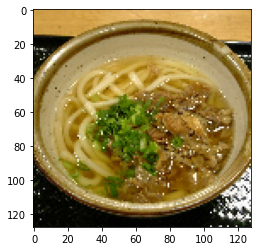

推定： うどん
正解： うどん


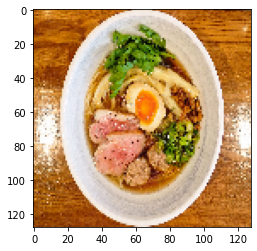

推定： ラーメン
正解： ラーメン


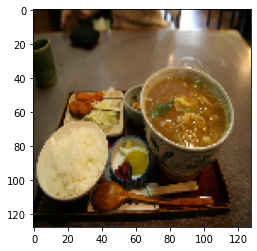

推定： うどん
正解： うどん


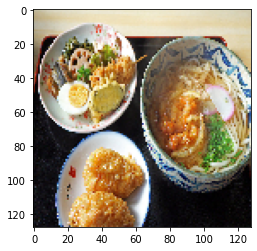

推定： うどん
正解： うどん


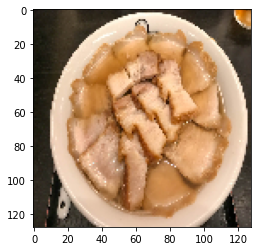

推定： ラーメン
正解： ラーメン


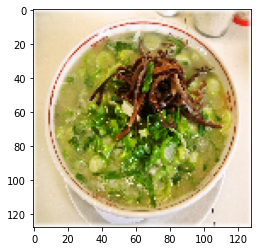

推定： ラーメン
正解： ラーメン


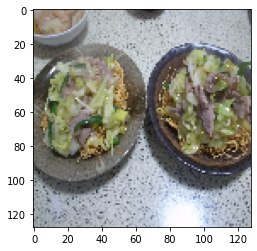

推定： うどん
正解： うどん


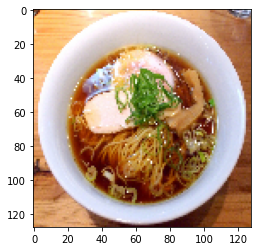

推定： ラーメン
正解： ラーメン


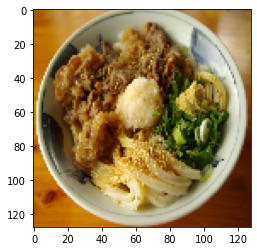

推定： うどん
正解： うどん


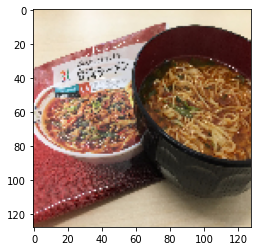

推定： うどん
正解： ラーメン


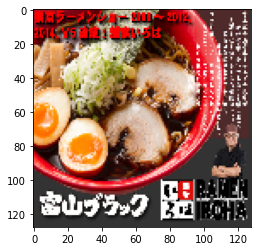

推定： ラーメン
正解： ラーメン


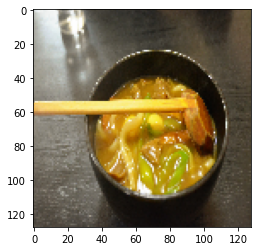

推定： うどん
正解： うどん


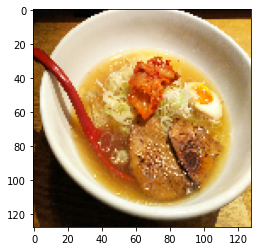

推定： ラーメン
正解： ラーメン


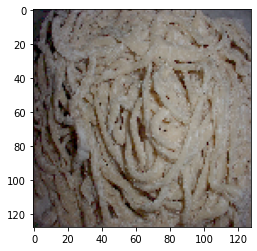

推定： うどん
正解： うどん


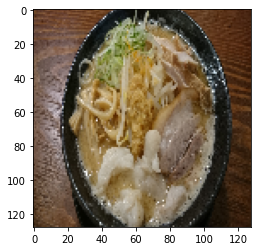

推定： ラーメン
正解： ラーメン


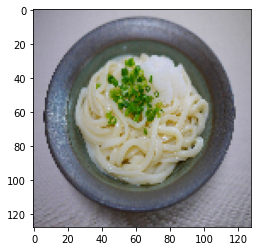

推定： うどん
正解： うどん


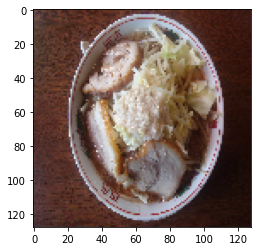

推定： ラーメン
正解： ラーメン


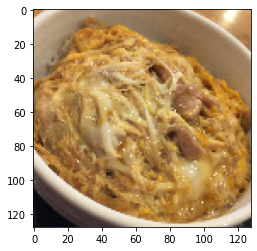

推定： ラーメン
正解： うどん


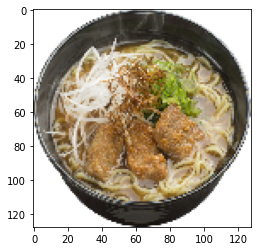

推定： ラーメン
正解： ラーメン


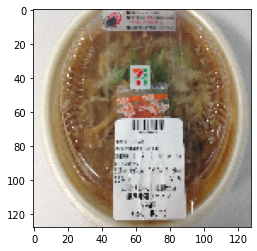

推定： ラーメン
正解： ラーメン


In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

code_to_class = {0: 'ラーメン', 1: 'うどん'}

x, y = next(test_generator)
y_true = np.argmax(y, axis=1)
y_prob = model.predict_on_batch(x)
y_pred = np.argmax(y_prob, axis=1)

for i in range(len(x)):
    plt.imshow(x[i])
    plt.show()
    print('推定：', code_to_class[y_pred[i]])
    print('正解：', code_to_class[y_true[i]])

In [22]:
# 混同行列で見てみる
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[12  4]
 [ 3 13]]


[[12  4]
 [ 3 13]]


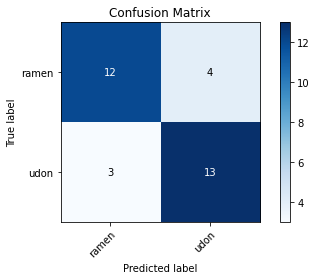

In [23]:
# おまけ
# 混同行列をもっと見やすく (参考: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['ramen', 'udon']

np.set_printoptions(precision=2)
plot_confusion_matrix(y_true, y_pred, classes=class_names)
plt.show()

今回は、畳込みニューラルネットワークを使った方がうまく分類できるようです。ただ、性能改善のために過学習対策を行う必要があるでしょう。